<a href="https://colab.research.google.com/github/lotrmay/TensorFlow_Learning/blob/master/bc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
%tensorflow_version 2.x
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from google.colab import drive
import pickle

import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
from IPython.display import clear_output #jen pro tenhle notebook
from six.moves import urllib
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import utils as np_utils
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import keras

#CSV_COLUMN_NAMES označuje nadpisy sloupců v csv soubour
CSV_COLUMN_NAMES=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg','Match_link','Result','team_one_name','team_two_name']
CSV_COLUMN_NAMES2=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg']

train=pd.read_csv('/content/pokus.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)#vytvoří dataframe z našeho csv souboru
print(train.shape)#vypíše nám dimenzionalitu našeho dataframu (2, 3) 2 řádky 3 sloupce

#následující 2 řádky nám upraví dva sloupce z textových na číselné formáty (category datatype)
train['team_one_name']=pd.Categorical(train['team_one_name']).codes #sníží využití paměti z 1.2MB na 0.03 MB viz: https://towardsdatascience.com/staying-sane-while-adopting-pandas-categorical-datatypes-78dbd19dcd8a
train['team_two_name']=pd.Categorical(train['team_two_name']).codes

#Odstraním z dataframu následující sloupce (odkaz na zápas a jména týmů), jelikož jsem je využíval pouze při sběru dat
train.pop('Match_link')
train.pop('team_one_name')
train.pop('team_two_name')
#https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
#frac=1 znamená, vrať všechny řádky
train = train.sample(frac=1).reset_index(drop=True)
#predictors nám vybere všechny sloupce, které jsou využity pro predikování výsledků neboli target_column
target_column = ['Result'] 

predictionScaler=StandardScaler()
y = train['Result'].values
train.pop('Result')
X = train.values


(18930, 102)


In [48]:
#určíme outliers (odlehlé hodnoty, které by mohly být při tréninku pro model škodlivé)
#zkráceně řečeno zjistíme odlehlou hodnotu tak, že ve svém okolí má oproti jiným hodnotám o dost méně "sousedů"
#5% dat 
lof = LocalOutlierFactor(contamination=0.1,n_neighbors=96)
yhat = lof.fit_predict(X)
mask = yhat != -1
X, y= X[mask, :], y[mask]
print(X.shape)


(17037, 98)


In [49]:

#rozdělíme náš dataframe na trénovací, testovací a validační dataset
#testovací dataset bude 15% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)#32 #888 887

#validační set bude 15% 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1764) # 0.1764 x 0.859 = 0.15 
print(X_train.shape) 
print(X_test.shape)
print(X_val.shape) 

#scalujeme data aby si model nemyslel, že větší číselný řád indikuje větší důležitost atributu
#https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
#https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler

#nepoužíváme minmaxscaler, protože naše data by měly být "normálně" distribuovány

X_train = pd.DataFrame(X_train, columns=CSV_COLUMN_NAMES2)
X_test=pd.DataFrame(X_test, columns=CSV_COLUMN_NAMES2)
X_val=pd.DataFrame(X_val, columns=CSV_COLUMN_NAMES2)

predictionScaler.fit(X_train)

X_train=predictionScaler.transform(X_train)#fit transform na training data viz:https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
X_test=predictionScaler.transform(X_test)
X_val=predictionScaler.transform(X_val)

(11926, 98)
(2556, 98)
(2555, 98)


Epoch 1/200
94/94 [==============================] - 1s 6ms/step - loss: 0.6607 - binary_accuracy: 0.6007 - val_loss: 0.6302 - val_binary_accuracy: 0.6446

Epoch 00001: val_loss improved from inf to 0.63017, saving model to current_model.h5
Epoch 2/200
94/94 [==============================] - 0s 4ms/step - loss: 0.6313 - binary_accuracy: 0.6418 - val_loss: 0.6137 - val_binary_accuracy: 0.6560

Epoch 00002: val_loss improved from 0.63017 to 0.61366, saving model to current_model.h5
Epoch 3/200
94/94 [==============================] - 0s 4ms/step - loss: 0.6265 - binary_accuracy: 0.6501 - val_loss: 0.6162 - val_binary_accuracy: 0.6622

Epoch 00003: val_loss did not improve from 0.61366
Epoch 4/200
94/94 [==============================] - 0s 4ms/step - loss: 0.6217 - binary_accuracy: 0.6616 - val_loss: 0.6074 - val_binary_accuracy: 0.6669

Epoch 00004: val_loss improved from 0.61366 to 0.60745, saving model to current_model.h5
Epoch 5/200
94/94 [==============================] - 0s 5ms/st

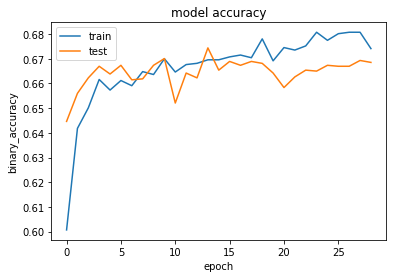

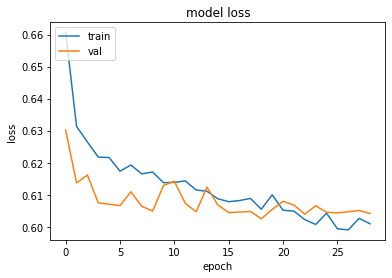

In [314]:
#data máme připravena, tak vytvoříme sequential model, jelikož potřebujeme mít více vrstev, ale máme pouze 1 input (zápas) a output 0;1
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=(98)))#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
model.add(keras.layers.Dropout(rate=0.2)) 
model.add(Dense(32,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(Dense(16,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(Dense(8,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
              metrics=['binary_accuracy'])

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001,verbose=1)
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('current_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
earlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)#patience-kolik epoch se nezmění val_loss pak stop

history = model.fit(X_train, y_train, epochs=200, shuffle=True,batch_size=128,validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr_callback,checkpoint_callback,earlyStopping_callback])
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))#úspěšnost na trénovacím setu   


pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))#úspěšnost na testovacím setu

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [315]:
#model.save('/content/save/703model.h5')
model= keras.models.load_model("current_model.h5")
scaledData=predictionScaler.transform(X)
pred_test= model.predict(scaledData)
scores2 = model.evaluate(scaledData, y, verbose=1)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on the whole dataset: {}% \n Error on the whole dataset: {}'.format(scores2[1], 1 - scores2[1]))#úspěšnost na testovacím setu


#pickle.dump(predictionScaler, open("/content/save/scaler703.pkl", 'wb'))#save the scaler 

533/533 [==============================] - 1s 2ms/step - loss: 0.5860 - binary_accuracy: 0.6893
Accuracy on the whole dataset: 0.6893232464790344% 
 Error on the whole dataset: 0.3106767535209656


In [213]:
predictionScaler = pickle.load(open("scaler703.pkl", 'rb'))
Xnew=np.array([[2.65,1.45,91,33,0.69,0.52,0.5,0.469,1.14,0.59,0.73,1.09,73.4,0.71,0.3,1.20,2.8,1.13,0.63,0.71,1.2,75.6,0.72,0.62,1.15,3.5,1.1,0.66,0.73,1.05,78.3,0.66,0.54,1.00,3.5,1.09,0.64,0.73,0.94,76.5,0.7,0.7,1.09,3.1,0.97,0.64,0.73,0.83,65.0,0.57,0.51,0.88,5.1,1.18,0.64,0.74,1.13,83.0,0.77,0.53,1.21,4.7,1.15,0.6,0.72,1.16,76.3,0.72,0.34,1.19,4.2,1.05,0.73,0.69,1.14,78.6,0.68,0.58,0.93,5.8,1.02,0.64,0.73,0.86,69.2,0.65,0.45,1.02,3.3,0.84,0.71,0.65,0.77,60.4,0.54,0.43,0.77,3.8],
               [1.84,1.9,98,111,0.9,0.75,0.5,0.5,1.4,0.57,0.81,1.31,93.4,0.92,0.51,1.62,6.2,1.31,0.63,0.76,1.38,90.8,0.79,0.45,1.25,11.3,1.19,0.52,0.77,1.07,70.8,0.73,0.59,1.41,5.7,1.18,0.59,0.75,1.12,75.8,0.74,0.23,1.25,6.1,1.17,0.62,0.74,1.21,81.4,0.67,0.47,1.07,9.7,1.28,0.54,0.73,1.28,79.9,0.85,0.38,1.57,1.9,1.18,0.62,0.75,1.09,81.7,0.73,0.53,1.17,4.5,1.13,0.62,0.74,1.08,75.9,0.73,0.54,1.16,4.6,1.11,0.65,0.74,1.09,76.3,0.69,0.41,1.06,4.5,1.12,0.62,0.76,0.94,77.1,0.67,0.54,1.08,5.4],
               [2.02,1.7,89,50,0.63,0.53,0.5,0.456,1.36,0.64,0.77,1.46,95.3,0.88,0.6,1.36,7.8,1.2,0.59,0.76,1.09,81.0,0.76,0.59,1.30,3.9,1.16,0.6,0.71,1.24,76.3,0.72,0.28,1.20,4.0,1.08,0.7,0.7,1.21,75.5,0.68,0.51,0.97,5.1,1.01,0.56,0.73,0.82,63.2,0.59,0.62,1.06,4.3,1.17,0.58,0.73,1.17,76.0,0.72,0.28,1.24,4.1,1.09,0.7,0.67,1.21,80.5,0.72,0.59,1.03,5.8,1.07,0.64,0.71,1.04,74.0,0.66,0.47,1.03,5.2,1.01,0.65,0.68,0.95,72.7,0.65,0.53,1.00,4.9,0.88,0.66,0.67,0.75,61.3,0.53,0.47,0.80,4.7],
               [1.79,1.95,22,20,0.44,0.59,0.5,0.491,1.05,0.63,0.71,0.87,76.9,0.66,0.5,1.04,4.5,1.03,0.68,0.67,1.1,72.0,0.68,0.58,1.01,4.5,1.0,0.65,0.68,0.97,65.6,0.62,0.28,0.96,3.2,0.95,0.65,0.69,0.82,68.2,0.59,0.41,0.92,5.1,0.92,0.75,0.62,1.02,70.8,0.61,0.5,0.81,4.9,1.19,0.56,0.73,1.12,75.9,0.74,0.29,1.33,4.1,1.16,0.66,0.7,1.2,86.6,0.76,0.44,1.15,8.0,1.11,0.65,0.73,1.04,75.8,0.72,0.55,1.11,3.2,1.02,0.66,0.72,0.99,68.0,0.62,0.54,0.94,3.9,0.93,0.68,0.69,0.82,67.5,0.58,0.6,0.84,4.2],
               [1.54,2.41,93,95,0.58,0.57,0.5,0.5,1.18,0.64,0.77,1.11,80.8,0.72,0.52,1.12,3.2,1.18,0.63,0.74,1.27,73.1,0.73,0.27,1.17,2.1,1.16,0.63,0.74,1.1,80.3,0.75,0.47,1.19,4.0,1.03,0.64,0.7,0.92,73.0,0.63,0.49,0.98,6.0,1.1375,0.635,0.7375,1.1,76.8,0.7075,0.4375,1.115,3.825,1.45,0.6,0.8,1.5,94.5,0.94,0.39,1.58,6.8,1.33,0.64,0.76,1.34,89.2,0.85,0.63,1.32,5.6,1.04,0.6,0.75,0.82,70.5,0.62,0.6,1.03,4.5,1.03,0.63,0.66,1.08,69.6,0.6,0.5,0.95,6.7,0.93,0.64,0.72,0.81,58.0,0.53,0.52,0.82,5.1],
               [2.7,1.44,84,45,0.53,0.41,0.51,0.606,1.24,0.66,0.73,1.31,88.1,0.82,0.53,1.25,3.2,1.13,0.68,0.7,1.21,80.4,0.74,0.5,1.09,5.6,1.11,0.65,0.71,1.17,73.1,0.71,0.32,1.09,1.9,0.97,0.68,0.69,0.83,70.6,0.61,0.52,0.90,4.7,1.1125,0.6675000000000001,0.7074999999999999,1.13,78.05,0.72,0.4675,1.0825,3.8500000000000005,1.19,0.56,0.75,1.18,72.2,0.73,0.27,1.31,2.6,1.12,0.66,0.69,1.21,79.7,0.72,0.52,1.08,6.5,0.97,0.69,0.68,0.9,71.2,0.62,0.53,0.91,7.9,0.95,0.69,0.66,0.95,69.6,0.61,0.61,0.89,4.2,0.94,0.66,0.69,0.81,67.5,0.58,0.53,0.88,5.2],
               [2.13,1.66,54,38,0.52,0.43,0.542,0.433,1.11,0.68,0.7,1.14,78.8,0.75,0.56,1.10,4.5,1.08,0.64,0.72,0.98,75.8,0.69,0.46,1.09,3.5,1.03,0.68,0.69,1.06,74.9,0.66,0.46,0.96,6.1,1.03,0.7,0.69,1.09,73.9,0.66,0.67,0.94,6.8,0.98,0.62,0.69,0.88,64.6,0.59,0.26,0.95,4.9,1.09,0.64,0.71,1.06,76.8,0.72,0.52,1.12,3.3,1.07,0.64,0.71,1.08,73.6,0.67,0.57,1.05,5.9,1.05,0.63,0.69,1.05,69.7,0.66,0.29,1.05,2.9,0.99,0.7,0.68,0.99,74.1,0.61,0.44,0.87,5.3,0.98,0.64,0.71,0.87,67.7,0.61,0.47,0.95,3.7],
               [2.08,1.7,33,42,0.52,0.5,0.469,0.521,1.18,0.64,0.74,1.13,83.0,0.77,0.53,1.21,4.7,1.15,0.6,0.72,1.16,76.3,0.72,0.34,1.19,4.2,1.05,0.73,0.69,1.14,78.6,0.68,0.58,0.93,5.8,1.02,0.64,0.73,0.86,69.2,0.65,0.45,1.02,3.3,0.84,0.71,0.65,0.77,60.4,0.54,0.43,0.77,3.8,1.15,0.7,0.71,1.24,85.4,0.75,0.52,1.08,4.3,1.09,0.64,0.7,1.04,75.6,0.73,0.36,1.14,3.4,1.02,0.64,0.7,0.92,71.6,0.63,0.53,0.98,5.1,0.99,0.67,0.68,0.94,69.5,0.65,0.55,0.97,3.1,0.98,0.67,0.69,0.92,69.6,0.61,0.5,0.92,4.6],
               [1.52,2.46,26,52,0.61,0.54,0.486,0.534,1.17,0.76,0.72,1.28,87.5,0.81,0.65,1.07,5.9,1.15,0.59,0.72,1.12,73.7,0.73,0.32,1.24,3.0,1.1,0.65,0.74,0.99,77.3,0.68,0.45,1.05,6.4,1.05,0.65,0.71,1.01,73.4,0.66,0.46,1.02,3.1,0.96,0.65,0.72,0.84,66.2,0.57,0.52,0.87,8.2,1.15,0.64,0.73,1.21,76.9,0.73,0.35,1.14,6.0,1.14,0.66,0.74,1.11,80.1,0.74,0.55,1.13,5.3,1.0,0.68,0.68,1.01,69.8,0.64,0.56,0.94,3.7,0.94,0.69,0.66,0.92,70.5,0.6,0.49,0.87,6.3,1.0575,0.6675,0.7025,1.0625,74.325,0.6775,0.4875,1.0199999999999998,5.325],
               [1.57,2.31,73,99,0.8,0.57,0.478,0.5,1.34,0.62,0.79,1.34,90.5,0.84,0.44,1.34,8.2,1.17,0.63,0.75,1.14,80.0,0.73,0.47,1.17,6.0,1.16,0.72,0.72,1.21,85.9,0.79,0.33,1.10,3.7,1.0,0.7,0.69,1.07,69.9,0.66,0.56,0.94,4.0,1.1675,0.6675,0.7374999999999999,1.19,81.57499999999999,0.755,0.45,1.1375,5.475,1.21,0.6,0.73,1.24,78.0,0.79,0.36,1.32,1.7,1.08,0.67,0.66,1.09,80.9,0.71,0.5,1.07,3.6,1.05,0.68,0.69,1.11,73.4,0.64,0.55,0.94,3.5,0.99,0.68,0.67,0.95,73.5,0.65,0.53,0.95,3.5,0.93,0.68,0.7,0.74,66.0,0.59,0.68,0.87,1.3], 
               [2.14,1.67,131,112,0.37,0.75,0.492,0.5,1.09,0.64,0.7,1.11,73.6,0.71,0.34,1.12,2.4,1.05,0.76,0.68,1.15,82.7,0.72,0.38,0.95,4.9,1.0,0.71,0.7,0.96,73.8,0.66,0.51,0.93,4.3,0.86,0.71,0.68,0.75,62.8,0.56,0.38,0.79,4.9,1.0,0.705,0.6900000000000001,0.9924999999999999,73.22500000000001,0.6625,0.40249999999999997,0.9475000000000001,4.125,1.15,0.65,0.71,1.25,77.7,0.77,0.54,1.18,2.8,1.2,0.65,0.7,1.38,78.2,0.81,0.2,1.25,1.9,1.08,0.69,0.72,0.95,83.2,0.7,0.44,1.02,6.9,1.03,0.7,0.71,0.97,77.8,0.65,0.45,0.93,7.0,0.97,0.71,0.69,0.94,71.8,0.62,0.41,0.87,3.5],
               [1.55,2.35,40,49,0.43,0.5,0.489,0.531,1.13,0.6,0.71,1.12,72.6,0.73,0.28,1.21,2.5,1.04,0.79,0.69,1.18,82.4,0.67,0.37,0.84,6.3,1.03,0.74,0.68,1.08,76.6,0.72,0.5,0.97,3.3,1.01,0.63,0.69,0.93,69.9,0.63,0.6,1.01,4.2,0.91,0.64,0.67,0.81,60.4,0.53,0.44,0.83,5.3,1.16,0.65,0.72,1.16,84.2,0.76,0.51,1.17,6.5,1.16,0.63,0.71,1.29,75.7,0.73,0.33,1.16,3.0,1.16,0.63,0.74,1.14,79.5,0.76,0.37,1.20,6.9,1.01,0.69,0.69,1.0,72.3,0.65,0.4,0.95,3.5,0.99,0.67,0.68,0.96,72.2,0.64,0.48,0.95,5.7]
])
Xnew = pd.DataFrame(Xnew, columns=CSV_COLUMN_NAMES2)
pokus=predictionScaler.transform(Xnew)
model= keras.models.load_model("703model.h5")
ynew=(model.predict([pokus]))
#ynew=(model.predict_classes([Xnew]))
print(ynew)


[[0.55200636]
 [0.5976912 ]
 [0.5047156 ]
 [0.5788419 ]
 [0.4106457 ]
 [0.6727999 ]
 [0.56046295]
 [0.5981078 ]
 [0.3094539 ]
 [0.3162776 ]
 [0.6393296 ]
 [0.30556357]]


In [316]:
n = 300 # Max number of neighbours you want to consider
param_grid = {'n_neighbors': np.arange(n)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(X,y)
print(grid.best_params_)
#pro 300 nabízí 153

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for 

{'n_neighbors': 153}


In [ ]:
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
pd.set_option("expand_frame_repr", True)
pd.set_option("large_repr", "info")
drive.mount('/content/drive')




poznatky-vypadá to, že grenade damage každého hráče je nadbytečná a síť bez této informace vykazuje lepší výsledky!!

optimální batch_size je 128 zjištěno zkoušením

kernel inity
he_uniform>he_normal
lecun uniform>lecun normal 
orthogonal a variance scaling použitelné

bias inity
lecun normal >he normal, variance_scaling
https://www.tensorflow.org/api_docs/python/tf/keras/initializers
val loss u callbacků nebo val_accuracy?
model.add(Dense(512, kernel_initializer=tf.initializers.lecun_uniform,bias_initializer=tf.initializers.lecun_normal))

nejlepší model měl zatím 512,256,128 i když to není doporučováno